<a href="https://colab.research.google.com/github/pavi-rajes/ao_functions_py/blob/Function-consolidation/dPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[38]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [ ]:
#@Import DPCA
!wget https://github.com/machenslab/dPCA/archive/master.tar.gz
!tar -xzf master.tar.gz
!pip install dPCA-master/python
import dPCA


--2020-07-30 17:26:16--  https://github.com/machenslab/dPCA/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/machenslab/dPCA/tar.gz/master [following]
--2020-07-30 17:26:16--  https://codeload.github.com/machenslab/dPCA/tar.gz/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘master.tar.gz.1’

master.tar.gz.1         [ <=>                ] 458.27K  --.-KB/s    in 0.06s   

2020-07-30 17:26:17 (6.91 MB/s) - ‘master.tar.gz.1’ saved [469270]

Processing ./dPCA-master/python
  Created wheel for dPCA: filename=dPCA-0.1-cp36-cp36m-linux_x86_64.whl size=268269 sha256=84bff0e973f4ed03bffc9151b8039f07b6c6841

In [ ]:
########################### function for normalization ###########################

def frNormalization(spk):
    spkz=np.sqrt(spk)
    spk_norm = np.zeros_like(spk)
    for cn in range(spkz.shape[0]):
        psth = spkz[cn, :, :]
        #print(psth.shape)
        for trn in range(psth.shape[0]):
            # trlSpk = psth[trn, :] - np.nanmean(psth[trn, :])
            trlSpk = stats.mstats.zscore(psth[trn, :], nan_policy='omit')
            spk_norm[cn, trn, :] = trlSpk 

            del trlSpk
        del psth
    return spk_norm

In [ ]:
#selecting correct answers 
feedback = dat["feedback_type"] # this is for selecting correct responses
conR = dat["contrast_right"]
conL = dat["contrast_left"]
decision = dat["response"]
spk = dat["spks"]
# spk = spk[:,:,:][feedback == 1]
spk = spk[:,feedback == 1,:]
spk.shape

conR2 = conR[feedback == 1]
conL2 = conL[feedback == 1] 

decision2 = decision[feedback == 1]
feedback2 = feedback[feedback == 1]
print(feedback2.shape)
print(spk.shape)



(246,)
(1348, 246, 250)


In [ ]:
conR2.shape

(246,)

In [ ]:
#@title Default title text
########################### get the selected regions normalized ###########################
allAreas = dat["brain_area"]
usedAreas = ['CA1', 'VISam', 'PL', 'MOs']
area=dict()
cellN=np.zeros(4)
for i in range(len(usedAreas)):
    areaId = allAreas == usedAreas[i]
    tmp_Area = spk[areaId, :, :]
    #print(tmp_Area.shape)
    area[i] = frNormalization(tmp_Area)
    cellN[i]=tmp_Area.shape[0]

# area contain normalized spikes from selected regions in usedAreas's order [index 0 -3 indicate each region]
# area: row: trials; col: time bins
print(area[0].shape)
print(area[1].shape)


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(47, 246, 250)
(126, 246, 250)


In [ ]:
# this is frome here: https://gist.github.com/derricw/95eab740e1b08b78c03f 
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

In [ ]:
new_n_bins = 25
firing_rate = dict()
for iA in range(len(area)):
  iN = area[iA].shape[0]
  iT = area[iA].shape[1]
  # take sum and divide by 0.1 to get firing rate in Hz
  firing_rate[iA]=bin_ndarray(area[iA],new_shape=(iN,iT,new_n_bins),operation='sum') / 0.1 
  print(firing_rate[iA].shape)
# print(firing_rate[0].shape)

(47, 246, 25)
(126, 246, 25)
(173, 246, 25)
(54, 246, 25)


In [ ]:
Xn = firing_rate[2] 



print(Xn.shape)
# print(R_Xn.shape)

(173, 246, 25)


In [ ]:
X_0 = Xn[:,decision2==0,:]
X_1 = Xn[:,decision2==1,:]
X_n1 = Xn[:,decision2==-1,:]
print(X_0.shape, X_1.shape,X_n1.shape)




(173, 86, 25) (173, 68, 25) (173, 92, 25)


In [ ]:
print(np.array(conL2==0.25).shape, np.array(conR2==1.0).shape)
print(conL2.shape)

print(np.argwhere(conL2==0.25).shape)

### Ranking based on contrast difference 

contrast_rank = np.zeros_like(conL2)
temp = np.zeros(len(contrast_rank))

for iL in range(len(conR2)):
  temp[iL] = np.abs(conL2[iL]-conR2[iL])

print(temp)
rank_idx = np.unique(temp)
print(rank_idx)

for iN in range(len(rank_idx)):
  rank_t = np.argwhere(temp== rank_idx[iN])
  contrast_rank[rank_t]= iN 

#rank_1 = np.argwhere(temp== rank_idx[1])
#contrast_rank[rank_1]= 1

print(contrast_rank)
print(contrast_rank.shape)

(246,) (246,)
(246,)
(37, 1)
[1.   1.   0.25 0.75 0.   0.25 0.25 0.   0.75 0.25 0.5  0.25 0.25 1.
 0.25 0.5  0.25 1.   0.   0.75 0.5  0.5  0.   0.5  0.75 0.25 1.   0.
 0.   1.   1.   0.5  0.25 1.   0.5  0.5  0.75 0.   0.5  1.   0.75 0.
 0.5  0.   0.75 1.   0.   0.   0.75 0.5  0.5  0.5  0.   0.25 0.   0.5
 0.   0.5  0.25 0.25 1.   0.5  0.5  0.75 0.   0.   0.   1.   0.   0.
 0.5  0.   0.   0.   0.   0.5  0.5  0.5  0.   0.5  0.   0.   1.   1.
 0.   0.25 0.   1.   1.   1.   1.   0.75 0.5  0.   0.5  0.   0.5  0.
 0.25 0.   0.   0.25 0.5  0.   1.   0.25 1.   0.   0.5  0.5  0.5  1.
 1.   0.5  0.5  0.   0.   0.   1.   0.5  0.5  0.75 0.5  0.   0.5  0.75
 0.5  1.   0.75 0.   0.25 0.   0.5  0.25 0.5  0.   0.   0.   1.   0.
 0.   0.25 0.   1.   0.25 0.5  0.   0.   0.25 0.75 0.25 0.5  0.75 0.25
 0.   1.   0.5  0.5  0.   0.5  0.   1.   0.   0.75 0.25 0.   1.   0.
 0.   0.75 1.   0.   0.5  0.25 0.   1.   0.5  0.5  0.   0.5  0.   0.
 0.5  0.75 0.5  0.   0.   0.   0.   1.   1.   0.75 1.   0.   0.5  0.


In [ ]:
import pandas as pd 

df = pd.DataFrame()

df['response'] = decision2

df['contrast_left'] = conL2
df['contrast_right'] = conR2

df['contrast_rank'] = contrast_rank

df['diff'] = conL2 - conR2

print(df)

     response  contrast_left  contrast_right  contrast_rank  diff
0         1.0           1.00            0.00            4.0  1.00
1        -1.0           0.00            1.00            4.0 -1.00
2        -1.0           0.00            0.25            1.0 -0.25
3         1.0           1.00            0.25            3.0  0.75
4         0.0           0.00            0.00            0.0  0.00
..        ...            ...             ...            ...   ...
241       0.0           0.00            0.00            0.0  0.00
242       0.0           0.00            0.00            0.0  0.00
243       0.0           0.00            0.00            0.0  0.00
244       0.0           0.00            0.00            0.0  0.00
245      -1.0           0.25            1.00            3.0 -0.75

[246 rows x 5 columns]


In [ ]:
X_right_1 = Xn[:,((decision2== -1.0) & (contrast_rank== 1.0)),:]
X_right_2 = Xn[:,((decision2== -1.0) & (contrast_rank== 2.0)),:]
X_right_3 = Xn[:,((decision2== -1.0) & (contrast_rank== 3.0)),:]
X_right_4 = Xn[:,((decision2== -1.0) & (contrast_rank== 4.0)),:]

X_left_1 = Xn[:,((decision2== 1.0) & (contrast_rank== 1.0)),:]
X_left_2 = Xn[:,((decision2== 1.0) & (contrast_rank== 2.0)),:]
X_left_3 = Xn[:,((decision2== 1.0) & (contrast_rank== 3.0)),:]
X_left_4 = Xn[:,((decision2== 1.0) & (contrast_rank== 4.0)),:]

X_nogo = Xn[:,((decision2== 0.0) & (contrast_rank== 0.0)),:]

print(X_right_1.shape)
print(X_right_4.shape)

print(X_left_4.shape)
print(X_nogo.shape)

(173, 26, 25)
(173, 25, 25)
(173, 19, 25)
(173, 86, 25)


In [ ]:
dim_4 = np.array([[-1,-1,-1,-1,1,1,1,1,0]])
print(dim_4.shape)

X_right_1_mean = X_right_1.mean(axis=1)
X_right_2_mean = X_right_2.mean(axis=1)
X_right_3_mean = X_right_3.mean(axis=1)
X_right_4_mean = X_right_4.mean(axis=1)

X_left_1_mean = X_left_1.mean(axis=1)
X_left_2_mean = X_left_2.mean(axis=1)
X_left_3_mean = X_left_3.mean(axis=1)
X_left_4_mean = X_left_4.mean(axis=1)

X_nogo_mean = X_nogo.mean(axis=1)


(1, 9)


In [ ]:
BigX = np.dstack([X_right_1_mean,X_right_2_mean,X_right_3_mean,X_right_4_mean,X_left_1_mean,X_left_2_mean,X_left_3_mean,X_left_4_mean,X_nogo_mean])
print(BigX.shape)

X_input = BigX[:,:,:,np.newaxis]+ dim_4
print(X_input.shape)

print(X_input[-1])
#X_input[:,:,:,0]= -1

#X_input[:,:,:,1]= -1 
#print(X_temp.shape)

(173, 25, 9)
(173, 25, 9, 9)
[[[ 1.30769231  1.30769231  1.30769231 ...  3.30769231  3.30769231
    2.30769231]
  [ 3.07407407  3.07407407  3.07407407 ...  5.07407407  5.07407407
    4.07407407]
  [14.71428571 14.71428571 14.71428571 ... 16.71428571 16.71428571
   15.71428571]
  ...
  [14.55555556 14.55555556 14.55555556 ... 16.55555556 16.55555556
   15.55555556]
  [-1.         -1.         -1.         ...  1.          1.
    0.        ]
  [ 1.20930233  1.20930233  1.20930233 ...  3.20930233  3.20930233
    2.20930233]]

 [[ 3.61538462  3.61538462  3.61538462 ...  5.61538462  5.61538462
    4.61538462]
  [ 5.66666667  5.66666667  5.66666667 ...  7.66666667  7.66666667
    6.66666667]
  [-1.         -1.         -1.         ...  1.          1.
    0.        ]
  ...
  [12.33333333 12.33333333 12.33333333 ... 14.33333333 14.33333333
   13.33333333]
  [-1.         -1.         -1.         ...  1.          1.
    0.        ]
  [ 6.44186047  6.44186047  6.44186047 ...  8.44186047  8.44186047
 

In [ ]:
# print(X_input.tolist)
# X_input = X_input[:,:,:,np.newaxis]+ dim_4
# print(X_input.shape)
#X_input = X_input.tolist
#print(X_input.type)
#X_input[:,:,:,0].type

(34, 25, 9, 1, 1, 1)


In [ ]:
####not running this one now 
X_0_mean = X_0[:,:,:].mean(axis=1)
X_1_mean = X_1[:,:,:].mean(axis=1)
X_n1_mean = X_n1[:,:,:].mean(axis=1)
print(X_0_mean.shape)

(34, 25)


In [ ]:
#### not running this cell now 

BigX = np.dstack([X_1_mean,X_n1_mean,X_0_mean]) # Order: Left, Right and No GO 
BigX.shape

(34, 25, 3)

In [ ]:
from dPCA import dPCA


In [ ]:

dpca = dPCA.dPCA(labels="std", n_components=10)
Z = dpca.fit_transform(X_input)

print(Z.keys())

dict_keys(['s', 't', 'd', 'st', 'sd', 'td', 'std'])


(10, 25, 9, 9) (10, 25, 9, 9)


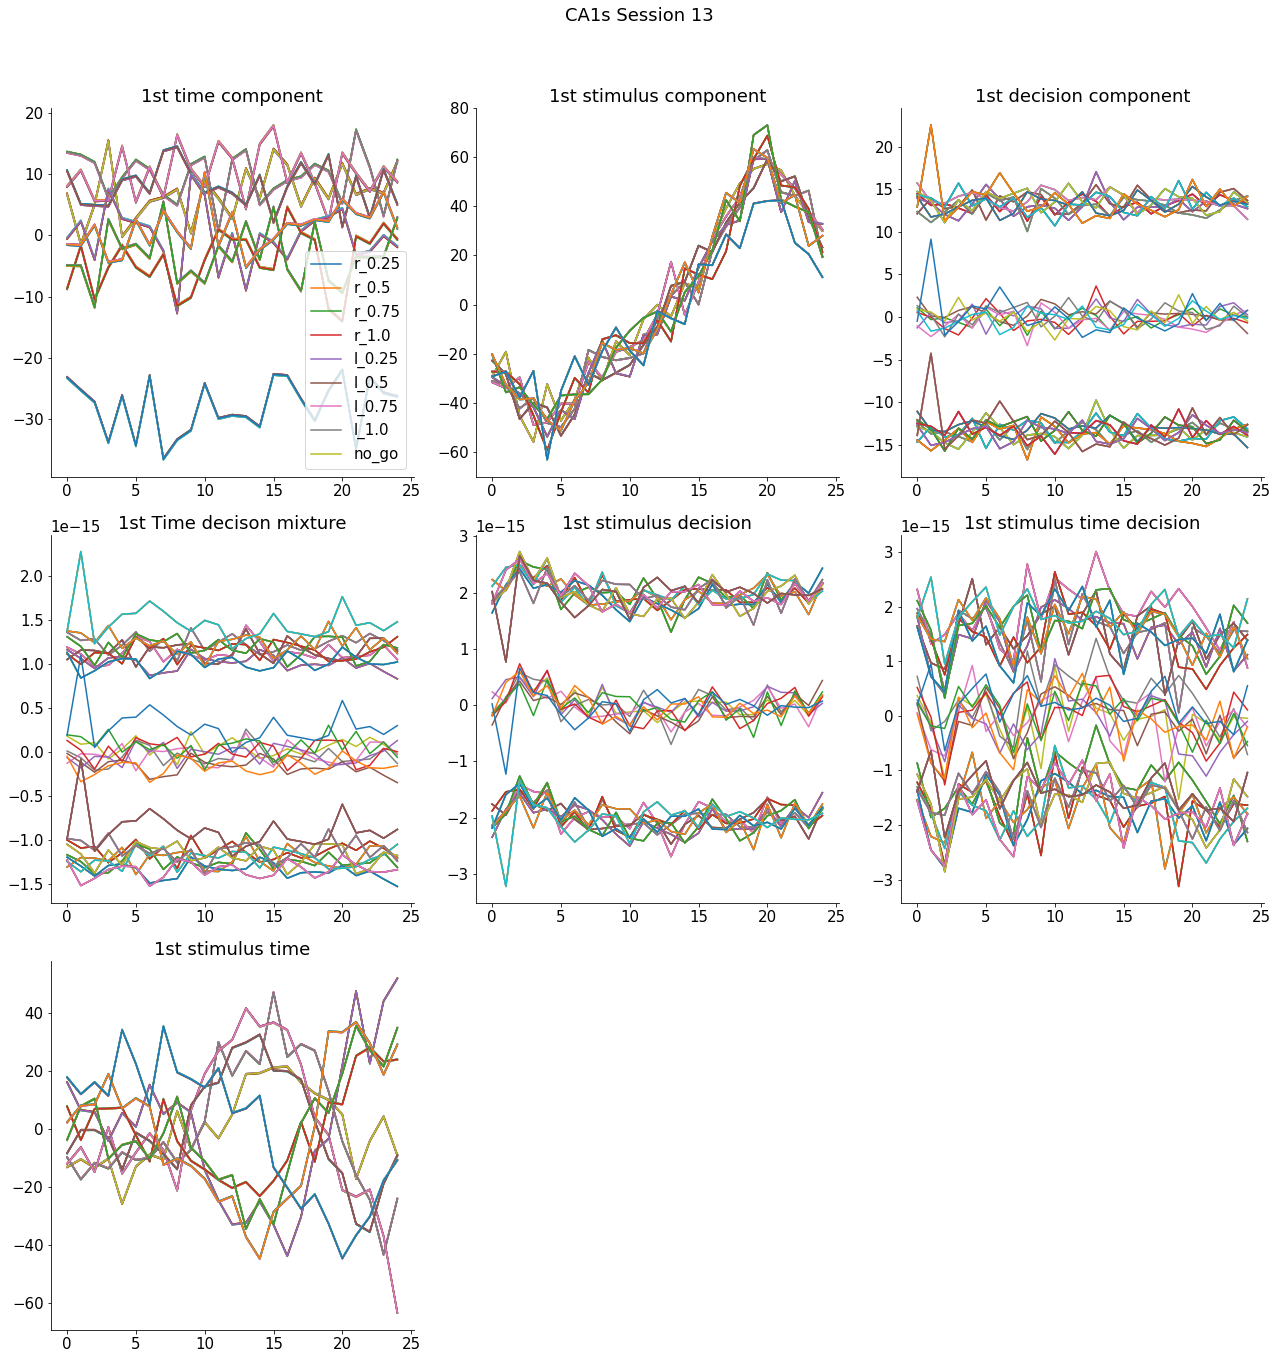

In [ ]:
time = np.arange(25)
Temp = Z['t']
Semp = Z['s']
Dem = Z['d']
Td = Z['td']
Sdem = Z['sd']
Zemp = Z['st']
STD = Z['std']
legend_values = ["r_0.25","r_0.5","r_0.75","r_1.0","l_0.25","l_0.5","l_0.75","l_1.0","no_go"]

plt.figure(figsize=(18,18))
plt.subplot(331)

for s in range(9):
    plt.plot(time,Temp[0,:,s])
    #plt.legend()

plt.title('1st time component')
plt.legend(legend_values)    
plt.subplot(332)

for s in range(9):
    plt.plot(time,Semp[0,:,s])
   
plt.title('1st stimulus component')
plt.subplot(333)

for s in range(9):
    plt.plot(time,Dem[0,:,:,s])
   
plt.title('1st decision component')
plt.subplot(334)


for s in range(9):
    plt.plot(time,Td[0,:,s])
   
plt.title('1st Time decison mixture')
plt.subplot(335)

for s in range(9):
    plt.plot(time,Sdem[0,:,s])
   
plt.title('1st stimulus decision')
plt.subplot(336)

for s in range(9):
    plt.plot(time,STD[0,:,s])
   
plt.title('1st stimulus time decision')
plt.subplot(337)


for s in range(9):
    plt.plot(time,Zemp[0,:,s])
    
    
plt.title('1st stimulus time')
plt.suptitle('CA1s Session 13', y = 1.05)
print(Temp.shape, Semp.shape)

In [ ]:
dpca = dPCA.dPCA(labels="ts", n_components=10)
Z_c = dpca.fit_transform(BigX)

print(Z_c.keys())

dict_keys(['t', 's', 'ts'])


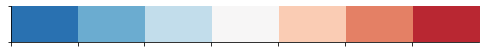

In [ ]:
import seaborn as sns

sns.palplot(sns.color_palette("RdBu_r", 7))

In [ ]:
explained_variance = dpca.explained_variance_ratio_
explained_variance
#print(explained_variance)

{'s': [0.02580983989896891,
  0.011151189159424521,
  0.006885733720831726,
  0.004366822080816554,
  0.0028597421729547306,
  0.0015528698948023988,
  0.0009037157065836763,
  0.0007988964725512954,
  1.874055106062039e-32,
  9.416572150457009e-33],
 't': [0.18931162803319454,
  0.08505375783743992,
  0.01660903917005483,
  0.011167558514491483,
  0.005628235042166542,
  0.004078824360612408,
  0.00328394721011249,
  0.0027334047791943046,
  0.0026919421141269493,
  0.0025563483419671325],
 'ts': [0.03688573958664373,
  0.02651908637658203,
  0.018313621722356337,
  0.011489272045912874,
  0.010249434777586743,
  0.010158470393776648,
  0.008897919341882535,
  0.008914352683837634,
  0.008873560163942355,
  0.007850258403864722]}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'upperleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'upperleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left


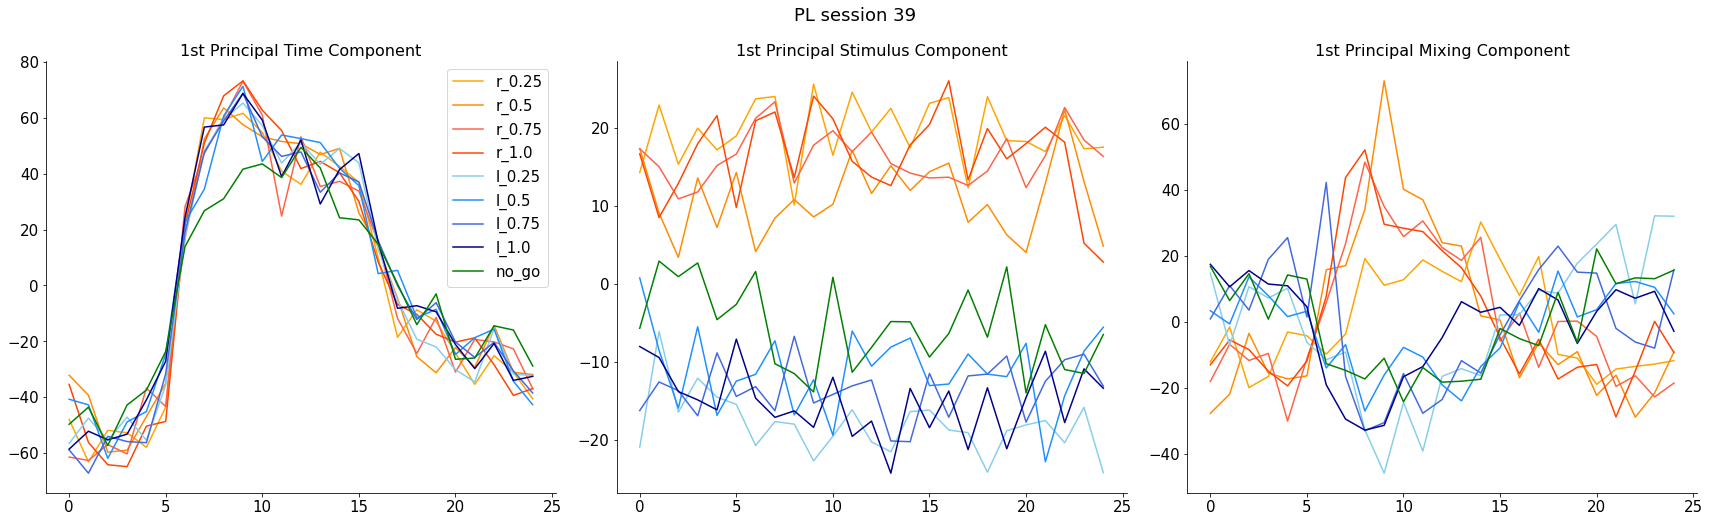

In [ ]:
time = np.arange(25)

s_c = Z_c['s']
t_c = Z_c['t']
st_c = Z_c['ts']

plt.figure(figsize=(24,7))
my_cmap = sns.color_palette("RdBu_r", 7)

color_palette = ["orange","darkorange","tomato","orangered","skyblue","dodgerblue","royalblue","darkblue","green"]
for s in range(9):
  plt.subplot(131)
  plt.plot(time,t_c[0,:,s],color=color_palette[s])
  plt.title('1st Principal Time Component',fontsize= 16)
  plt.legend(legend_values,loc='upperleft')

  plt.subplot(132)
  plt.plot(time,s_c[0,:,s],color=color_palette[s])
  plt.title('1st Principal Stimulus Component',fontsize= 16)

  plt.subplot(133)
  plt.plot(time,st_c[0,:,s],color=color_palette[s])
  plt.title('1st Principal Mixing Component',fontsize= 16)

  plt.suptitle('PL session 39',y=1.04,fontsize= 18)
  plt.tight_layout()
  plt.savefig('dPCA_PL_session39_contrast.png')

[0.18931163 0.27436539 0.29097443 0.30214198 0.30777022 0.31184904
 0.31513299 0.31786639 0.32055834 0.32311469]


Text(0.5, 1.0, 't')

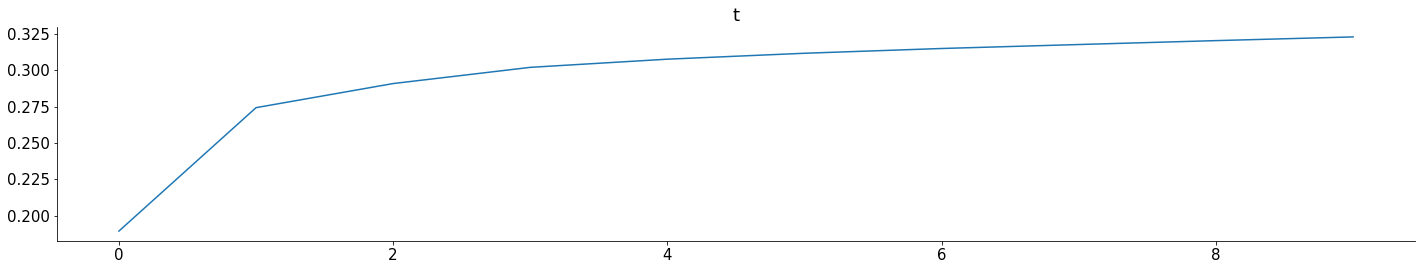

In [ ]:
print(np.cumsum(explained_variance['t'][:10]))

plt.plot(n_components, np.cumsum(explained_variance['t'][:10]))
plt.title('t')

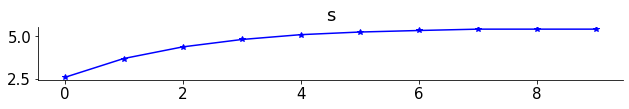

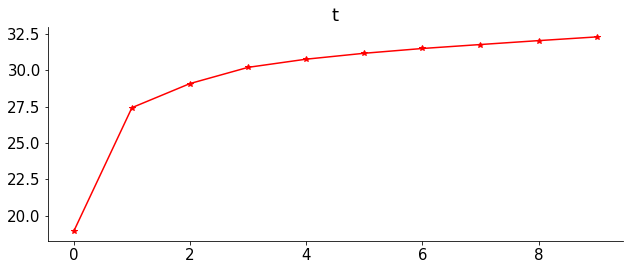

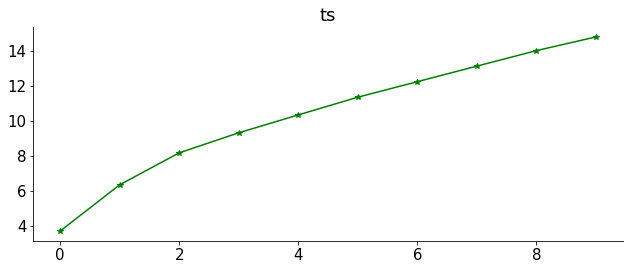

In [ ]:
#scree plot
n_components = np.arange(10)

#for n in range(10):
plt.figure(figsize=(9,4))
plt.subplot(311)
plt.plot(n_components, np.cumsum(explained_variance['s'][:10])*100,'*b')
plt.plot(n_components, np.cumsum(explained_variance['s'][:10])*100,'b')
plt.title('s')
plt.savefig('PL_explainedvariance_39_s.png')

#plt.subplot(312)
plt.figure(figsize=(9,4))
plt.plot(n_components, np.cumsum(explained_variance['t'][:10])*100,'*r')
plt.plot(n_components, np.cumsum(explained_variance['t'][:10])*100,'r')
plt.title('t')
plt.savefig('PL_explainedvariance_39_t.png')

#plt.plot(313)
plt.figure(figsize=(9,4))
plt.plot(n_components, np.cumsum(explained_variance['ts'][:10])*100,'*g')
plt.plot(n_components, np.cumsum(explained_variance['ts'][:10])*100,'g')
plt.title('ts')

plt.savefig('PL_explainedvariance_39_ts.png')

In [ ]:


A = Z['']

import pandas as pd 
names = ['x', 'y', 'z', 'p']
index = pd.MultiIndex.from_product([range(s)for s in A.shape], names=names)
df = pd.DataFrame({'A': A.flatten()}, index=index)['A']

AttributeError: ignored

(10, 9, 9)


ValueError: ignored

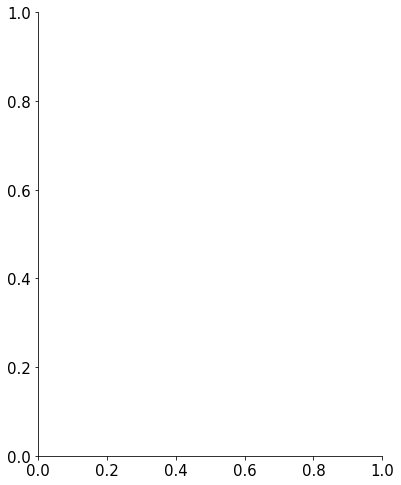

In [ ]:
# plt.figure(figsize=(18,18))
# plt.subplot(331)
# for s in range(9):
#     plt.plot(Semp,Temp[0,:,s])
#     #plt.legend()

# plt.title('1st time component')
# plt.legend(legend_values)    
# plt.subplot(332)

# for s in range(9):
#     plt.plot(time,Semp[0,:,s])
   
# plt.title('1st stimulus component')
# plt.subplot(333)

# for s in range(9):
#     plt.plot(time,Dem[0,:,s])
   
# plt.title('1st decision component')


New_semp = Semp.mean(axis = 1)
print(New_semp.shape)


plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(9):
    plt.plot(New_semp[0,s],Dem[0,:,s])
    #plt.legend()



ValueError: ignored

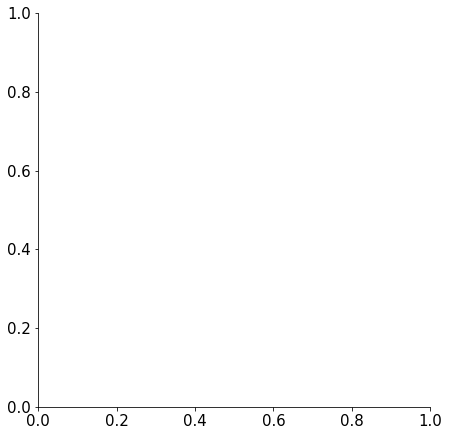

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(331)
for s in range(9):
    plt.plot(Semp[0,:,s],Dem[0,:,s])
    #plt.legend()

In [ ]:

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(9):
    plt.plot(time,Temp[0,:,s])
    #plt.legend()

plt.title('1st time component')
plt.legend(legend_values)    
plt.subplot(132)

for s in range(9):
    plt.plot(time,Semp[0,:,s])
   
plt.title('1st stimulus component')
plt.legend(legend_values)
plt.subplot(133)

for s in range(9):
    plt.plot(time,Zemp[0,:,s])
    
    
plt.title('1st mixing component')
plt.legend(legend_values)
plt.suptitle('MOs Session 39', y = 1.05)
print(Temp.shape, Semp.shape)

In [ ]:
import seaborn as sns
z_temp=Zemp[0,:,:]
print(z_temp.shape)
#for s in range(9):
plt.plot(time,z_temp)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: ignored

In [ ]:
explained_variance = dpca.explained_variance_ratio_
explained_variance

{'s': [0.09927270047363752,
  0.0275373155367755,
  4.858387611384074e-33,
  1.2674860510585356e-33,
  3.4120269740910385e-33,
  3.7084697882761273e-33,
  2.763011979064356e-33,
  2.6781383258328582e-33,
  1.0914938453772775e-33,
  1.8005448765177503e-33],
 't': [0.22157165101800824,
  0.04385893388909776,
  0.022252343132697416,
  0.014779689089505365,
  0.011804375742819303,
  0.009050147898532144,
  0.007052403613402061,
  0.005372638299745257,
  0.0035405105808092906,
  0.0034214661981035724],
 'ts': [0.09557812350234787,
  0.08413664399450448,
  0.035649935590469695,
  0.030027090720764878,
  0.02104229220953503,
  0.017831804519364346,
  0.013481809103276824,
  0.013527061726003976,
  0.009999984882661815,
  0.007813685389739504]}

NameError: ignored